In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data.DataLoader import load_and_preprocess_data

### Explorando o Dataset

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Carregar dataset
raw_dataset = pd.read_csv('data/output.csv')

label_name = "Stage"

# Verificar informações iniciais
print("Antes da conversão para numérico:")
print(raw_dataset.info())  # Ver tipos de dados
print(raw_dataset.head())  # Ver algumas amostras

Antes da conversão para numérico:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86699 entries, 0 to 86698
Data columns (total 85 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Flow ID                     86699 non-null  object
 1   Src IP                      86699 non-null  object
 2   Src Port                    86699 non-null  object
 3   Dst IP                      86699 non-null  object
 4   Dst Port                    86699 non-null  object
 5   Protocol                    86699 non-null  object
 6   Timestamp                   86699 non-null  object
 7   Flow Duration               86699 non-null  object
 8   Total Fwd Packet            86699 non-null  object
 9   Total Bwd packets           86699 non-null  object
 10  Total Length of Fwd Packet  86699 non-null  object
 11  Total Length of Bwd Packet  86699 non-null  object
 12  Fwd Packet Length Max       86699 non-null  object
 13  Fwd Packet L

#### Features com maior correlação com o estágio do ataque

Número de NaNs por coluna após conversão:
Flow ID      86699
Src IP       86699
Src Port         8
Dst IP       86699
Dst Port         8
             ...  
Idle Mean        8
Idle Std         8
Idle Max         8
Idle Min         8
Activity     86699
Length: 84, dtype: int64
Dataset final: 86691 linhas, 79 colunas


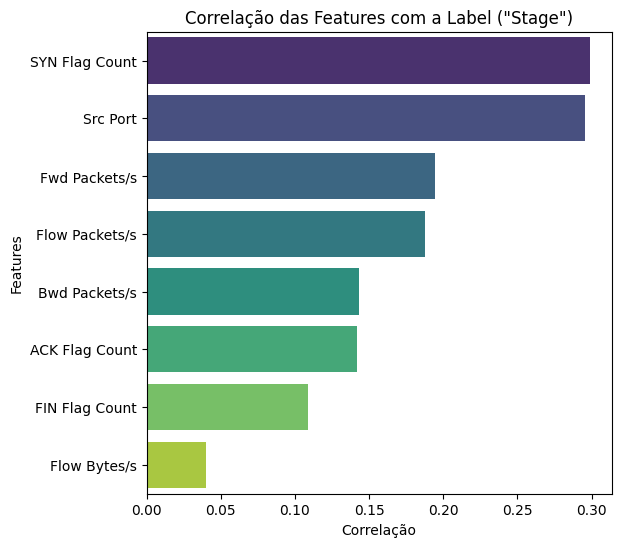

Attributos de maior correlação: ['SYN Flag Count', 'Src Port', 'Fwd Packets/s', 'Flow Packets/s', 'Bwd Packets/s', 'ACK Flag Count', 'FIN Flag Count', 'Flow Bytes/s']


In [37]:
# Converter a label para numérico (caso seja categórica)
if raw_dataset[label_name].dtype == object:
    raw_dataset[label_name] = pd.Categorical(raw_dataset[label_name]).codes

labels = raw_dataset[label_name]
raw_dataset = raw_dataset.drop(columns=[label_name])

# Converter colunas para numérico e diagnosticar
dataset = raw_dataset.apply(pd.to_numeric, errors='coerce')

# Ver quantos NaNs foram gerados após conversão
print("Número de NaNs por coluna após conversão:")
print(dataset.isna().sum())

# Se muitas colunas foram convertidas para NaN, tentar identificar o problema
if dataset.isna().sum().sum() > 0.9 * dataset.size:
    print("⚠️ Muitas colunas viraram NaN! Pode ser erro na conversão.")

# Remover colunas com 100% de NaNs
dataset = dataset.dropna(axis=1, how='all')

# Agora remover apenas linhas onde muitas colunas são NaN (evitar remover tudo)
dataset = dataset.dropna(thresh=int(0.5 * dataset.shape[1]))  # Mantém linhas com pelo menos 50% das colunas preenchidas
labels = labels.loc[dataset.index]  # Manter alinhamento

# Verificar se ainda há dados
print(f"Dataset final: {dataset.shape[0]} linhas, {dataset.shape[1]} colunas")

# Calcular correlação
correlation = dataset.corrwith(labels)

# Ordenar e plotar
correlation = correlation.sort_values(ascending=False)
positive_correlation = correlation[correlation > 0]

plt.figure(figsize=(6, 6))
sns.barplot(x=positive_correlation.values, y=positive_correlation.index, palette="viridis")
plt.xlabel("Correlação")
plt.ylabel("Features")
plt.title('Correlação das Features com a Label ("Stage")')
plt.show()
print(f"Attributos de maior correlação: {list(positive_correlation.index)}")

#### Menor sequência de ataque

In [ ]:
min_value = 15

current_label = labels[0]
current_count = 1
shortest_sequence = len(labels)
for label in labels[1:]:
    if label == current_label:
        current_count += 1
    elif current_count < shortest_sequence and current_count > min_value:
        shortest_sequence = current_count
        current_count = 1
        current_label = label

print(f"Menor sequência de labels iguais: {shortest_sequence}")

Menor sequência de labels iguais: 19
Sequência mais comum de labels iguais: (1, 4727)


In [ ]:
n_samples = 20000 #esse valor depende muito do seq_len, da amostragem, da quantidade de outliers e etc. No futuro era bom pensar em uma maneira de calcular isso automaticamente
seq_len = 20 #esse valor deve ser divisor de n_samples. Sendo 19 a menor sequência de labels iguais, 20 é um valor razoável para começar
features_to_train = list(positive_correlation.index.values) + ["Timestamp"]
train_set = load_and_preprocess_data("data/train.csv", features_to_train, "Stage", seq_len, n_samples)

Foram removidos 3518 outliers
X_train shape is (1000, 8, 1, 20)
y_train shape is (1000,)
Class benign has 945 samples
Class reconnaissance has 17 samples
Class establish foothold has 7 samples
Class lateral movement has 31 samples


In [5]:
x_train = train_set.X_train
y_train = train_set.Y_train

In [10]:
def plot_samples(data, classnames, labels = None, offset = 0):
    fig, axs = plt.subplots(2, 5, figsize=(20, 5))
    fig.suptitle(f'Network Traffic', fontsize=15)  # Exemplo de título, ajuste conforme necessário

    colors = ['b', 'r']  # Azul para a primeira variável, vermelho para a segunda

    for i in range(2):
        for j in range(5):
            axs[i, j].plot(data[i*2 + j + offset, 1, 0, :], color=colors[1], label=classnames[1])
            axs[i, j].plot(data[i*2 + j + offset, 0, 0, :], color=colors[0], label=classnames[0])

    #change the background color based on the label
    if labels is not None:
        for i in range(2):
            for j in range(5):
                if labels[i*5 + j + offset] == 0:
                    axs[i, j].set_facecolor('lightgreen')
                else:
                    axs[i, j].set_facecolor('lightcoral')

    # Criar uma única legenda para toda a figura
    handles = [plt.Line2D([0], [0], color=colors[k], lw=2) for k in range(len(classnames))]
    fig.legend(handles, classnames, loc='upper right', fontsize=12)

    plt.show()



In [11]:
def plot_n_samples(data, classnames, num_samples, labels=None, offset = 0):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['b', 'r']  # Azul para a primeira variável, vermelho para a segunda
    count = 0

    for i in range(num_samples):
        seq_len = data.shape[-1]
        x = np.arange(seq_len) + count  # Ajusta a posição no eixo x para evitar sobreposição
        ax.plot(x, data[i + offset, 0, 0, :], color=colors[0], label=classnames[0] if i == 0 else "")
        ax.plot(x, data[i + offset, 1, 0, :], color=colors[1], label=classnames[1] if i == 0 else "")
        count += seq_len  # Move o próximo conjunto de dados para a direita

    if labels is not None:
        for i in range(num_samples):
            if labels[i + offset] == 0:
                ax.axvspan(i * seq_len, (i + 1) * seq_len, color='lightgreen', alpha=0.5)
            else:
                ax.axvspan(i * seq_len, (i + 1) * seq_len, color='lightcoral', alpha=0.5)

    plt.title("Trafego de rede")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.show()

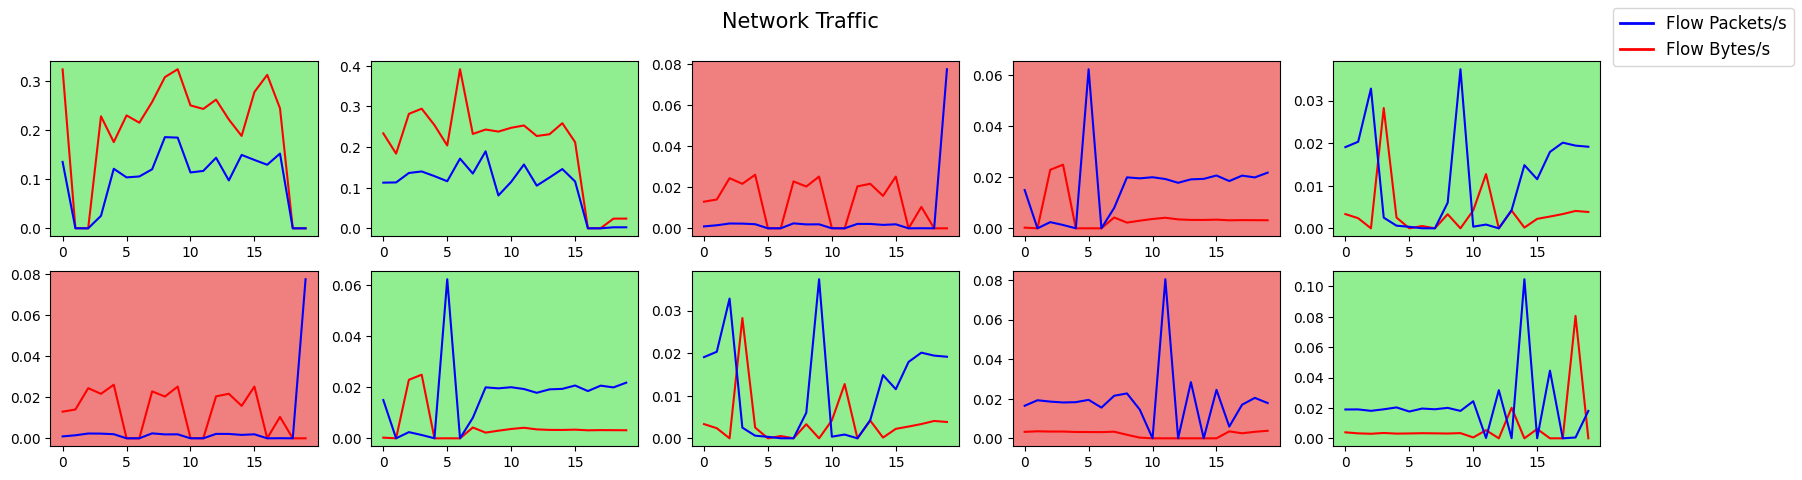

In [14]:
plot_samples(x_train, ['Flow Packets/s', 'Flow Bytes/s'], y_train, 300)


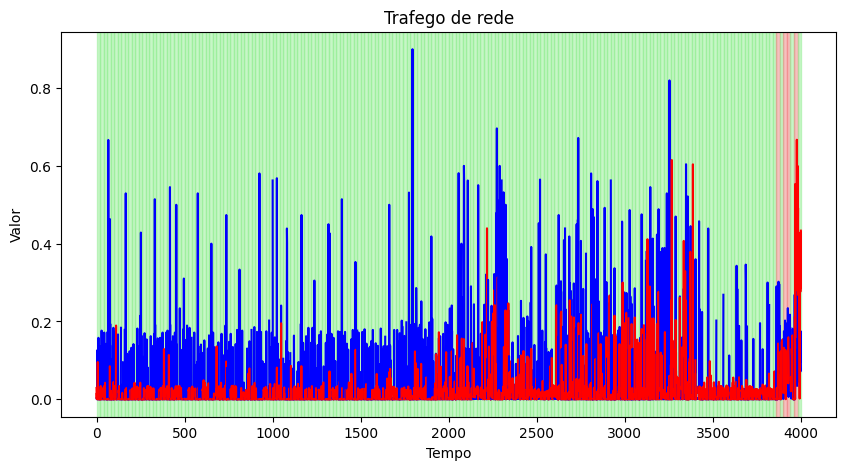

In [13]:
plot_n_samples(x_train, ['Flow Packets/s', 'Flow Bytes/s'], 200, y_train, 100)

## Gerando dados sinteticos

In [2]:
import matplotlib.pyplot as plt
from gan.generate_data import *

In [ ]:
data_path = "data/train.csv"
CGAN_model_path = 'logs\mitbithCGAN_2025_03_05_18_03_08\Model\checkpoint'
feature_names = ['Timestamp', 'Flow Packets/s', 'Flow Bytes/s']
seq_len = 20

x_synt, y_real = recreate_dataset(data_path, CGAN_model_path, feature_names, seq_len)

X_train shape is (1000, 2, 1, 20)
y_train shape is (1000,)
Class 0 has 268 samples
Class 1 has 684 samples
Class 2 has 16 samples
Class 3 has 3 samples
Class 4 has 29 samples


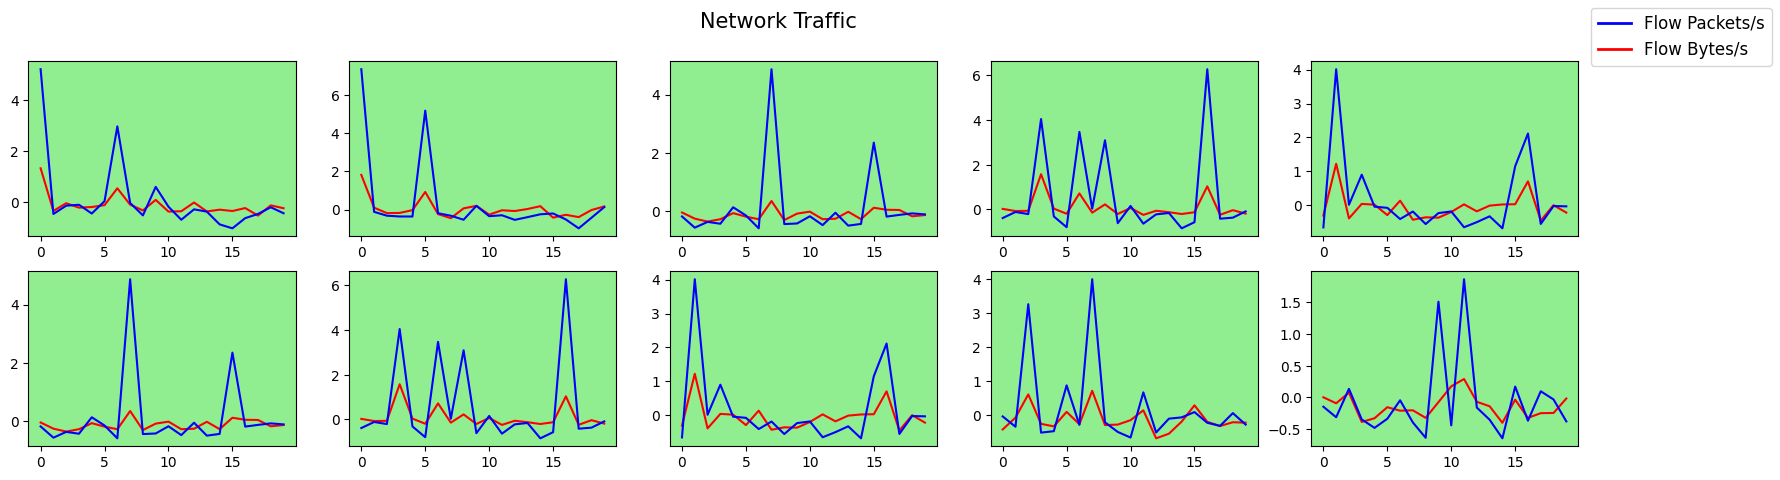

In [14]:
plot_samples(x[0:10, :], ['Flow Packets/s', 'Flow Bytes/s'], y[0:10], 0)

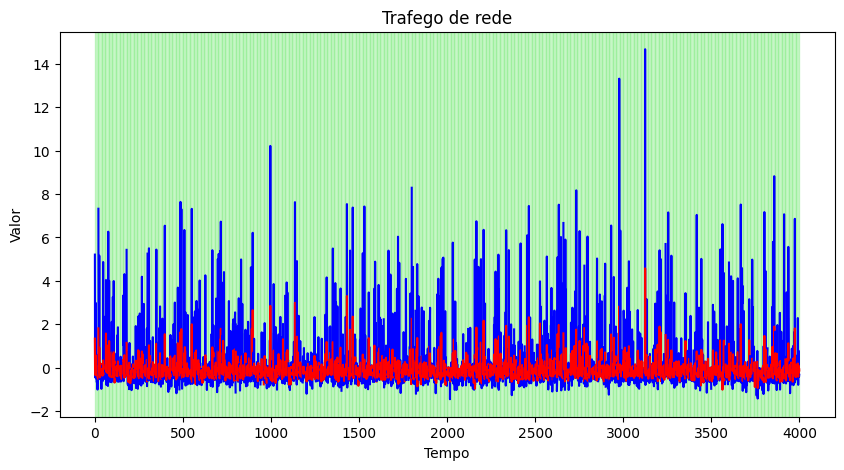

In [17]:
plot_n_samples(x, ['Flow Packets/s', 'Flow Bytes/s'], 200, y)

In [ ]:
class_dict = {'Non-Ectopic Beats':0, 'Superventrical Ectopic':1, 'Ventricular Beats':2, 'Unknown':3, 'Fusion Beats':4}
def plot_synthetic_heartbeat(classname):
    synthetic_data = [] 
    synthetic_labels = []
    for i in range(10):
        fake_noise = torch.FloatTensor(np.random.normal(0, 1, (1, 100)))
        fake_label = torch.tensor([class_dict[classname]])
        fake_sigs = gen_net(fake_noise, fake_label).to('cpu').detach().numpy()

        synthetic_data.append(fake_sigs)
        synthetic_labels.append(fake_label)

    fig, axs = plt.subplots(2, 5, figsize=(20,5))
    fig.suptitle(f'Synthetic HeartBeat {classname}', fontsize=15)
    for i in range(2):
        for j in range(5):
            axs[i, j].plot(synthetic_data[i*5+j][0][0][0][:])
            axs[i, j].title.set_text(synthetic_labels[i*5+j])

In [ ]:
class_dict = {'Non-Ectopic Beats':0, 'Superventrical Ectopic':1, 'Ventricular Beats':2, 'Unknown':3, 'Fusion Beats':4}
def plot_synthetic_heartbeat(classname):
    synthetic_data = [] 
    synthetic_labels = []
    for i in range(4):
        fake_noise = torch.FloatTensor(np.random.normal(0, 1, (1, 100)))
        fake_label = torch.tensor([class_dict[classname]])
        fake_sigs = gen_net(fake_noise, fake_label).to('cpu').detach().numpy()

        synthetic_data.append(fake_sigs)
        synthetic_labels.append(fake_label)

    fig, axs = plt.subplots(1, 4, figsize=(15,5))
    fig.suptitle(f'Synthetic {classname}', fontsize=15)
    for i in range(4):
        axs[i].plot(synthetic_data[i][0][0][0][:])
    plt.savefig(f'./syn_{classname}.pdf', format="pdf")

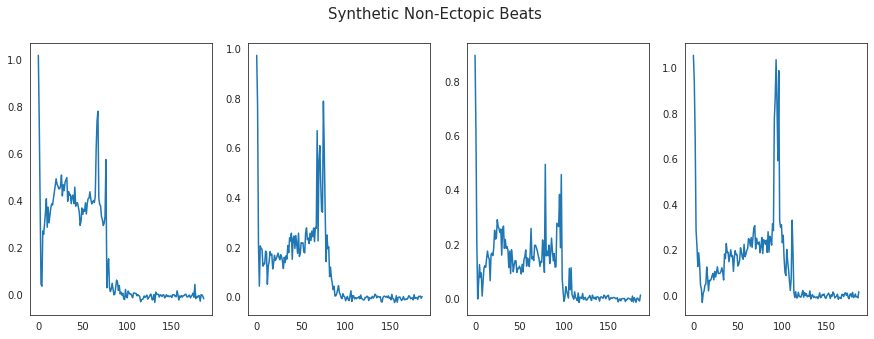

In [ ]:
plot_synthetic_heartbeat('Non-Ectopic Beats')

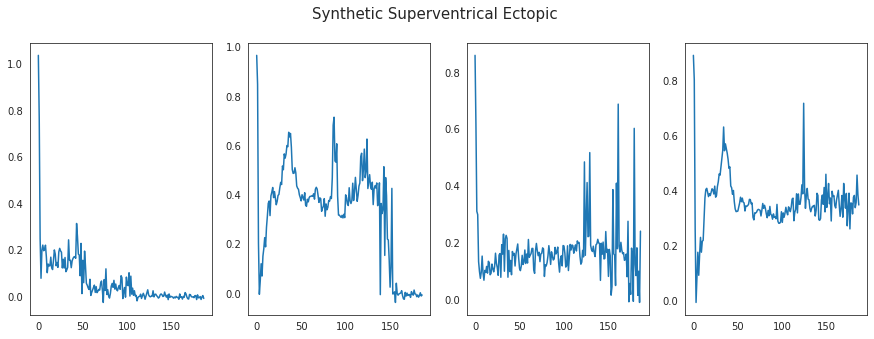

In [ ]:
plot_synthetic_heartbeat('Superventrical Ectopic')

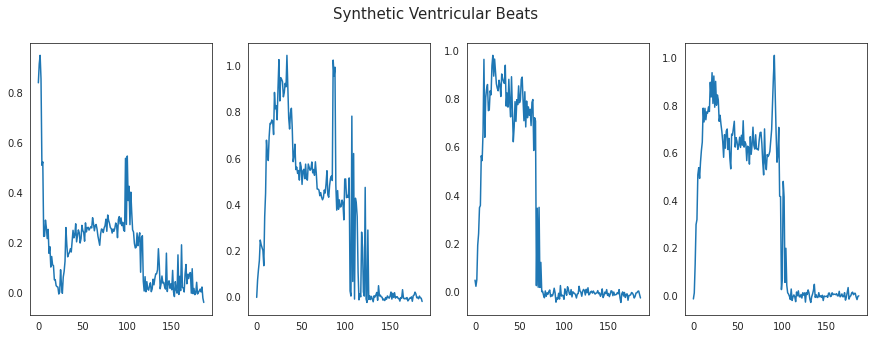

In [ ]:
plot_synthetic_heartbeat('Ventricular Beats')

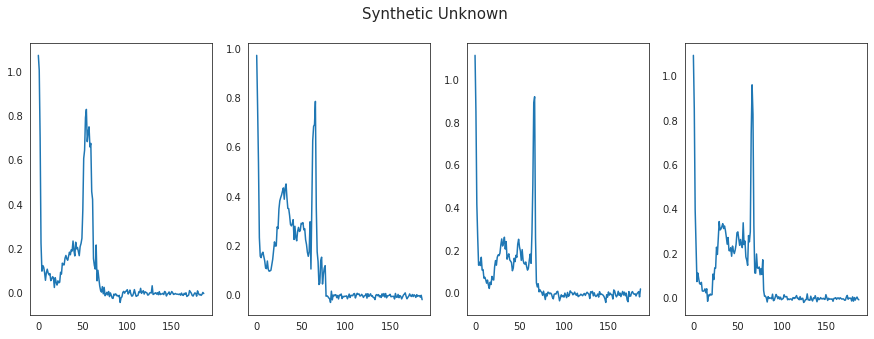

In [ ]:
plot_synthetic_heartbeat('Unknown')

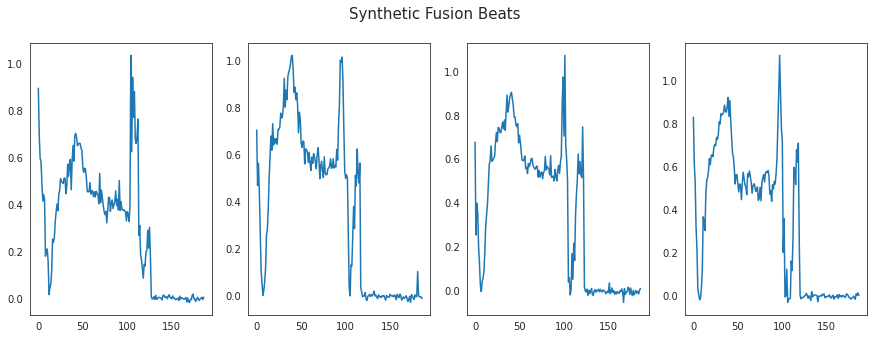

In [ ]:
plot_synthetic_heartbeat('Fusion Beats')

In [ ]:
from synDataLoader import *
from torch.utils import data

In [ ]:
syn_ecg = syn_mitbih(n_samples=1000, reshape=True)

data shape is (5000, 187)
labels shape is (5000,)
The dataset including 1000 class 0, 1000 class 1, 1000 class 2, 1000 class 3, 1000 class 4


In [ ]:
def plot_hist_syn(data,start,size,bins, filename="test_syn"):
    sigs=data[:, start:size]
#     end = start+size
#     sigs=sigs[:,start:end]
    sigs_flatten=sigs.flatten()

    final1=np.arange(start,size)
    for i in range (sigs.shape[0]-1):
        tempo1=np.arange(start,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(sigs_flatten))
    plt.hist2d(final1,sigs_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.savefig(f'{filename}.pdf')
    plt.show()

In [ ]:
def plot_hist(data,start,size,bins, filename="test_real"):
    sigs=data.iloc[:, start:size].to_numpy()
#     end = start+size
#     sigs=sigs[:,start:end]
    sigs_flatten=sigs.flatten()

    final1=np.arange(start,size)
    for i in range (sigs.shape[0]-1):
        tempo1=np.arange(start,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(sigs_flatten))
    plt.hist2d(final1,sigs_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.savefig(f'{filename}.pdf')
    plt.show()

65000
65000


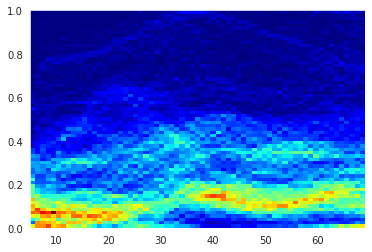

In [ ]:
plot_hist(data_0[:1000],5,70,65, "data_0_real")

65000
65000


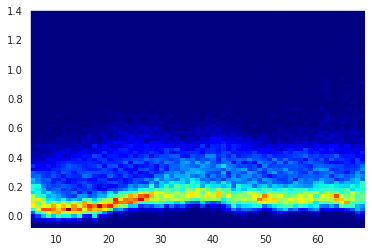

In [ ]:
plot_hist_syn(syn_ecg.syn_0,5,70,65, "data_0_syn")

45000
45000


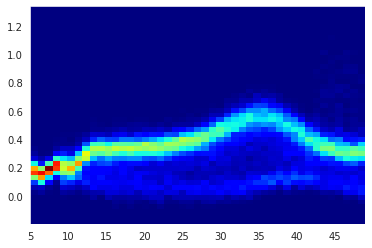

In [ ]:
plot_hist_syn(syn_ecg.syn_1,5,50,45, "data_1_syn")

45000
45000


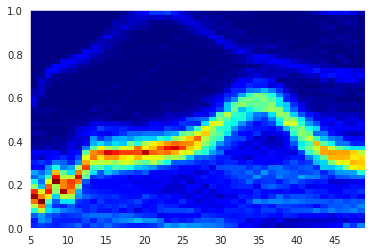

In [ ]:
plot_hist(data_1[:1000],5,50,45, "data_1_real")

45000
45000


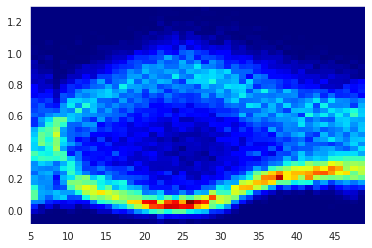

In [ ]:
plot_hist_syn(syn_ecg.syn_2,5,50,45, "data_2_syn")

45000
45000


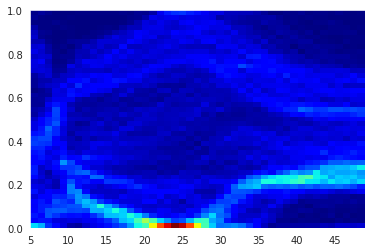

In [ ]:
plot_hist(data_2[:1000],5,50,45, "data_2_real")

45000
45000


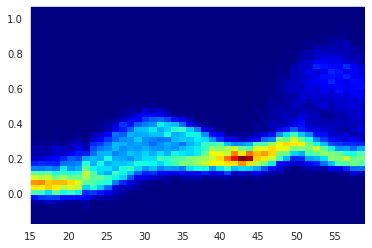

In [ ]:
plot_hist_syn(syn_ecg.syn_3,15,60,45, "data_3_syn")

28845
28845


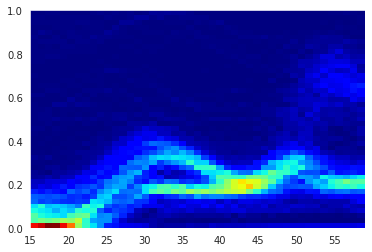

In [ ]:
plot_hist(data_3[:1000],15,60,45, "data_3_real")

45000
45000


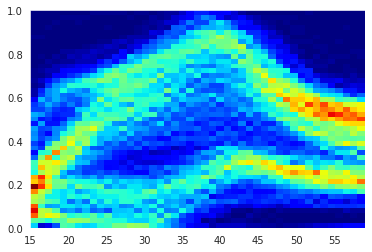

In [ ]:
plot_hist(data_4[:1000],15,60,45, "data_4_real")

45000
45000


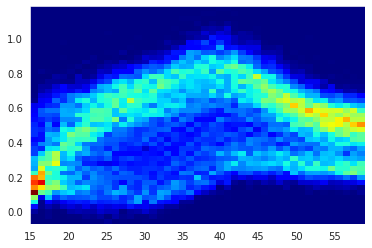

In [ ]:
plot_hist_syn(syn_ecg.syn_4,15,60,45, "data_4_syn")